In [1]:
import numpy as np
import joblib
import torch
import os
import geopandas as gpd
import sys

import cmocean as cm

from scipy.ndimage import binary_erosion
from scipy.spatial.distance import cdist

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Adjust the path to your project root directory where 'models' folder is located
project_root = os.path.abspath('../../../')  # or the relative path to your root from the notebook folder

if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.models.cnn import CNN_AE
from src.inputs import GaussianInputs
from src.optimizer import GPOptimizer, DeepGPOptimizer
from src.utils import *

In [ ]:
states = gpd.read_file(f'{project_root}/data/massachusetts/s_08mr23.shp')
mass = states[states['NAME']=='Massachusetts']

xmin = -71.25+0.05
xmax = -69.75-0.05
ymin = 41.6+0.05
ymax = 42.8-0.05

In [ ]:
tstep = 11129
latent_dim = 30
acquisition_function = 'LCB'
seed = 0

In [ ]:
grid_x = np.load(f'{project_root}/data/fvcom/grid_x.npy')
grid_y = np.load(f'{project_root}/data/fvcom/grid_y.npy')
grid_x_m, grid_y_m = sp_proj('forward', grid_x, grid_y,  'm')

t = np.load(f'{project_root}/data/fvcom/t.npy')
u = np.load(f'{project_root}/data/fvcom/u_interp.npy')
v = np.load(f'{project_root}/data/fvcom/v_interp.npy')

mask = np.isnan(u[0,:,:])

nt, ngrid, _ = u.shape

u_fill, v_fill = u.copy(), v.copy()
u_fill[:, mask] = 0
v_fill[:, mask] = 0

base_dir = f'{project_root}/results/fvcom/bo/constant_flow/{tstep}'

In [ ]:
dt = 3600
ndays = 0.75
T = ndays*24*60*60
dts = [dt for _ in range(int(T / dt))]
num_traj = 5

In [ ]:
safe_mask = binary_erosion(~mask, structure=np.ones((12, 12)))  
yy, xx = np.where(safe_mask)
coords = np.array(list(zip(xx, yy)))

In [ ]:
u_true = u[tstep, :,:]
v_true = v[tstep, :,:]
omega_true = vort_FVCOM(u_true, v_true, grid_x_m, grid_y_m)
psi_true = streamfunction_FVCOM(omega_true, grid_x_m, grid_y_m)

omega_true = omega_true*1e5

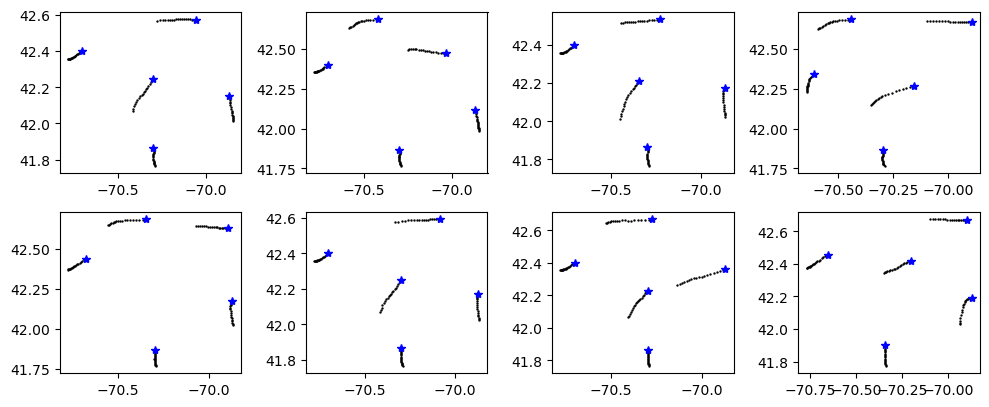

In [ ]:
dt = 0.05
T = 1
dts = [dt for _ in range(int(T / dt))]

num_traj = 5
num_exp = 1000

exp_vals = list(np.arange(num_exp))
exp_vals_copy = exp_vals.copy()

np.random.seed(seed)
idx0 = {}
for exp_i in range(num_exp):
    selected = [coords[np.random.randint(len(coords))]]
    idx0[exp_i] = {'x0': [selected[0][0]], 'y0': [selected[0][1]]}
    for _ in range(num_traj - 1):
        min_dists = cdist(coords, np.array(selected)).min(axis=1)
        selected.append(coords[np.argmax(min_dists)])
        idx0[exp_i]['x0'].append(selected[-1][0])
        idx0[exp_i]['y0'].append(selected[-1][1])

trajectories = {}
for exp_i in exp_vals:
    trajectories[exp_i] = {}
    exp_str = f'exp_x0_{"_".join(map(str, idx0[exp_i]["x0"]))}_y0_{"_".join(map(str, idx0[exp_i]["y0"]))}'
    exp_dir = os.path.join(base_dir, exp_str)
    for traj_i in range(num_traj):
        traj_path = os.path.join(exp_dir, f'traj_{traj_i}.npy')     
        trajectories[exp_i][traj_i] = np.load(traj_path)

plt.figure(figsize=(10,int(np.ceil(num_exp/4))*2))

for exp_i in range(8):        
    ax = plt.subplot(int(np.ceil(num_exp/4)), 4, exp_i+1)
    c = plot_trajectories_lines(trajectories[exp_i])
plt.tight_layout()

In [ ]:
nn = CNN_AE(latent_dim=latent_dim)
nn.load_state_dict(torch.load(f"{project_root}/src/models/checkpoints/fvcom/cnn_{latent_dim}_model.pth"))
nn.to(device)
D = nn.decode

data, nn_scaler = transform_data_for_AE(u,v)
latent_space = get_latent_space(nn, data)

latent_inputs = gaussian_kde(latent_space)

 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning:Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1719512383855/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)


In [ ]:
optimizers = {}
for exp_i in exp_vals:
    optimizers[exp_i] =  DeepGPOptimizer(trajectories[exp_i], dts, trajectory_cost_function, D, latent_inputs, grid_x, grid_y, nn_scaler, device, acquisition_function, n_init=0, train_init=False)

In [ ]:
load_data = True

if load_data:
    base_path = f'{project_root}/results/fvcom/bo/constant_flow/{tstep}'
    subfolder = f'{acquisition_function}_{latent_dim}'

    for exp_i in exp_vals:
        exp_str = f'exp_x0_{"_".join(map(str, idx0[exp_i]["x0"]))}_y0_{"_".join(map(str, idx0[exp_i]["y0"]))}'
        exp_path = os.path.join(base_path, exp_str, subfolder)

        if not os.path.exists(exp_path):
            print(f'Warning: {exp_path} does not exist. Skipping...')
            exp_vals_copy.remove(exp_i)
            continue

        optimizer = optimizers[exp_i]
        optimizer.X = np.load(os.path.join(exp_path, 'X.npy'))
        optimizer.Y = np.load(os.path.join(exp_path, 'Y.npy'))

        optimizer.scaler_gp_x = joblib.load(os.path.join(exp_path, 'scaler_gp_x.joblib'))
        optimizer.scaler_gp_y = joblib.load(os.path.join(exp_path, 'scaler_gp_y.joblib'))

exp_vals = exp_vals_copy

In [ ]:
z_opt, u_opt, v_opt, w_opt, psi_opt, traj_opt = [], [], [], [], [], []
u_err, v_err, w_err, psi_err = [], [], [], []
for exp_i in exp_vals:
    optimizer = optimizers[exp_i]

    k=1
    
    if k == 1:
        z_i, u_i, v_i, traj_i = optimizer.get_optimal()
        w_i = vort_FVCOM(u_i, v_i, grid_x_m, grid_y_m)
        psi_i = streamfunction_FVCOM(w_i, grid_x_m, grid_y_m)
        w_i = w_i*1e5
    else:
        _, _, _, traj_i = optimizer.get_top_k(k=k)
        u_i, v_i = optimizer.get_top_k_mean(k=k)


    u_opt.append(u_i)
    v_opt.append(v_i)
    w_opt.append(w_i)
    psi_opt.append(psi_i)
    traj_opt.append(traj_i)

    u_err.append(u_true - u_i)
    v_err.append(v_true - v_i)
    w_err.append(omega_true - w_i)
    psi_err.append(psi_true - psi_i)

 /home/bchamp/anaconda3/envs/ocean-flow/lib/python3.8/site-packages/torch/nn/modules/conv.py:456: UserWarning:Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/envs/bld/conda-bld/pytorch-select_1719512383855/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)


In [ ]:
# Compute the average of absolute errors across all samples
avg_u_err = np.mean([np.abs(err) for err in u_err], axis=0)
avg_v_err = np.mean([np.abs(err) for err in v_err], axis=0)
avg_w_err = np.mean([np.abs(err) for err in w_err], axis=0)
avg_psi_err = np.mean([np.abs(err) for err in psi_err], axis=0)

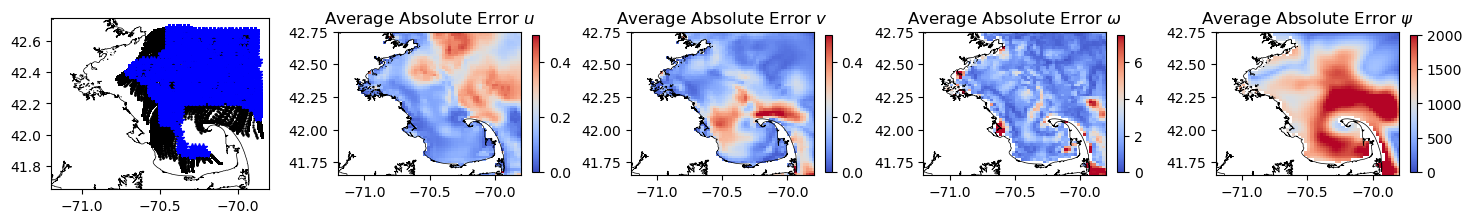

In [ ]:
# Define error types and their respective properties
error_types = [
    {'name': 'u', 'data': avg_u_err, 'vmin': 0, 'vmax': 0.5, 'title': 'Average Absolute Error $u$'},
    {'name': 'v', 'data': avg_v_err, 'vmin': 0, 'vmax': 0.5, 'title': 'Average Absolute Error $v$'},
    {'name': '\omega', 'data': avg_w_err, 'vmin': 0, 'vmax': 7.5, 'title': 'Average Absolute Error $\omega$'},
    {'name': '\psi', 'data': avg_psi_err, 'vmin': 0, 'vmax': 2000, 'title': 'Average Absolute Error $\psi$'}
]

# Plot the average errors
plt.figure(figsize=(15, 2.2))
for i, error in enumerate(error_types, 1):
    ax = plt.subplot(1, 5, i+1)
    plt.pcolormesh(grid_x, grid_y, error['data'], cmap='coolwarm', vmin=error['vmin'], vmax=error['vmax'])
    ax.set_aspect('equal')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.colorbar(shrink=0.8)
    plt.title(error['title'])
    mass.boundary.plot(ax=ax, color='black', linewidth=0.5) 
    ax.set_aspect('equal')

ax = plt.subplot(1, 5, 1)
for exp_i in range(num_exp):
    # for traj_i in range(num_traj):
        # plt.scatter(trajectories[exp_i][traj_i][0, 0], trajectories[exp_i][traj_i][0, 1], color='black', alpha=0.2, s=1)
    plot_trajectories_lines(trajectories[exp_i])
mass.boundary.plot(ax=ax, color='black', linewidth=0.5)    
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal')    


plt.tight_layout()
# plt.savefig(f'FVCOM_Figures/constant_flow_{tstep}_average_error_{num_exp}_{acquisition_function}_{latent_dim}.png', dpi=300, bbox_inches='tight')
plt.show()


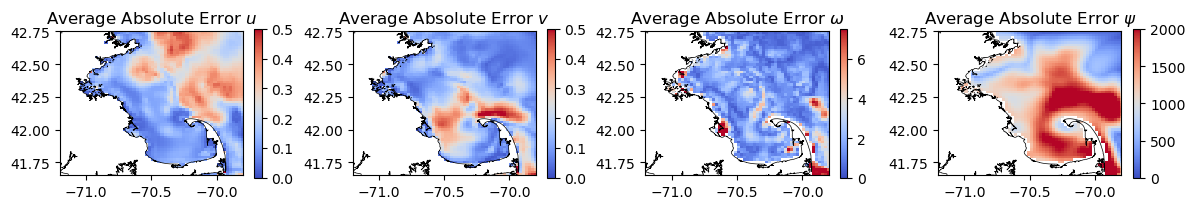

In [ ]:
# Define error types and their respective properties
error_types = [
    {'name': 'u', 'data': avg_u_err, 'vmin': 0, 'vmax': 0.5, 'title': 'Average Absolute Error $u$'},
    {'name': 'v', 'data': avg_v_err, 'vmin': 0, 'vmax': 0.5, 'title': 'Average Absolute Error $v$'},
    {'name': '\omega', 'data': avg_w_err, 'vmin': 0, 'vmax': 7.5, 'title': 'Average Absolute Error $\omega$'},
    {'name': '\psi', 'data': avg_psi_err, 'vmin': 0, 'vmax': 2000, 'title': 'Average Absolute Error $\psi$'}
]

# Plot the average errors
plt.figure(figsize=(12, 2.2))
for i, error in enumerate(error_types):
    ax = plt.subplot(1, 4, i+1)
    plt.pcolormesh(grid_x, grid_y, error['data'], cmap='coolwarm', vmin=error['vmin'], vmax=error['vmax'])
    ax.set_aspect('equal')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.colorbar(shrink=0.8)
    plt.title(error['title'])
    mass.boundary.plot(ax=ax, color='black', linewidth=0.5) 
    ax.set_aspect('equal')



plt.tight_layout()
plt.savefig(f'{project_root}/figures/fvcom/bo/constant_flow_{tstep}_average_error_{num_exp}_{acquisition_function}_{latent_dim}.png', dpi=300, bbox_inches='tight')
plt.show()


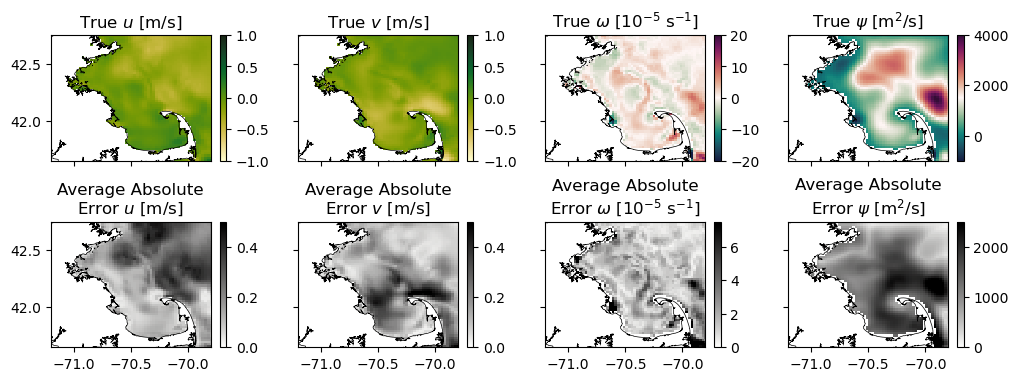

In [ ]:
# Define error types and their respective properties
error_types = [
    {'name': 'u', 'data': avg_u_err, 'vmin': 0, 'vmax': 0.5, 'title': 'Average Absolute\nError $u$', 'units': 'm/s'},
    {'name': 'v', 'data': avg_v_err, 'vmin': 0, 'vmax': 0.5, 'title': 'Average Absolute\nError $v$', 'units': 'm/s'},
    {'name': '\omega', 'data': avg_w_err, 'vmin': 0, 'vmax': 4, 'title': 'Average Absolute\nError $\omega$', 'units': '$10^{-5}$ s$^{-1}$'},
    {'name': '\psi', 'data': avg_psi_err, 'vmin': 0, 'vmax': 2500, 'title': 'Average Absolute\nError $\psi$', 'units': 'm$^2$/s'}
]

true_types = [
        {'name': 'u', 'data': u_true, 'title': 'True $u$', 'vmin': -1, 'vmax': 1, 'cmap': cm.cm.speed, 'units': 'm/s'},
        {'name': 'v', 'data': v_true, 'title': 'True $v$', 'vmin': -1, 'vmax': 1, 'cmap': cm.cm.speed, 'units': 'm/s'},
        {'name': '\omega', 'data': omega_true, 'title': 'True $\omega$', 'vmin': -5, 'vmax': 5, 'cmap': cm.cm.curl, 'units': '$10^{-5}$ s$^{-1}$'},
        {'name': '\psi', 'data': psi_true, 'title': 'True $\psi$', 'vmin': -1000, 'vmax': 4000, 'cmap': cm.cm.curl, 'units': 'm$^2$/s'}
]

cb_shrink=1

fig, axes = plt.subplots(2, 4, figsize=(10, 3.7), constrained_layout=True, sharex=True, sharey=True)
# Plot true values (top row)
for i, true in enumerate(true_types):
    ax = plt.subplot(2, 4, i+1)
    mass.boundary.plot(ax=ax, color='black', linewidth=0.5)
    pcm = plt.pcolormesh(grid_x, grid_y, true['data'], cmap=true['cmap'], vmin=true['vmin'], vmax=true['vmax'])
    ax.set_aspect('equal')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.colorbar(pcm, ax=ax, shrink=cb_shrink)
    plt.title(true['title'] + f' [{true["units"]}]')

# Plot average errors (bottom row)
for i, error in enumerate(error_types):
    ax = plt.subplot(2, 4, i+5)
    mass.boundary.plot(ax=ax, color='black', linewidth=0.5)
    pcm = plt.pcolormesh(grid_x, grid_y, error['data'], cmap=cm.cm.gray_r, vmin=error['vmin'], vmax=error['vmax'])
    ax.set_aspect('equal')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.colorbar(pcm, ax=ax, shrink=cb_shrink)
    plt.title(error['title'] + f' [{error["units"]}]')

plt.savefig(f'{project_root}/figures/fvcom/bo/constant_flow_{tstep}_average_error_{num_exp}_{acquisition_function}_{latent_dim}_with_true.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Compute RMSE for each sample and variable
rmse_u = [np.sqrt(np.nanmean(err**2)) for err in u_err]
rmse_v = [np.sqrt(np.nanmean(err**2)) for err in v_err]
rmse_w = [np.sqrt(np.nanmean(err**2)) for err in w_err]
rmse_psi = [np.sqrt(np.nanmean(err**2)) for err in psi_err]

# Print mean and standard deviation of RMSE across 1000 samples
print("u:   mean RMSE = {:.4f}, std = {:.4f}".format(np.nanmean(rmse_u), np.nanstd(rmse_u)))
print("v:   mean RMSE = {:.4f}, std = {:.4f}".format(np.nanmean(rmse_v), np.nanstd(rmse_v)))
print("w:   mean RMSE = {:.4f}, std = {:.4f}".format(np.nanmean(rmse_w), np.nanstd(rmse_w)))
print("psi: mean RMSE = {:.4f}, std = {:.4f}".format(np.nanmean(rmse_psi), np.nanstd(rmse_psi)))

u:   mean RMSE = 0.2423, std = 0.0268
v:   mean RMSE = 0.2107, std = 0.0208
w:   mean RMSE = 3.0514, std = 0.5259
psi: mean RMSE = 1485.7179, std = 367.0484
